# IMPORTING ALL REQUIRED LIBRARIES AT ONCE

In [1]:
# importing required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORTING ALL DATA FILES

In [2]:
# importing all 3 csv files
customers = pd.read_csv(r"C:\Users\Acer\OneDrive\Desktop\ZEOTAP ASSIGNMENT\Customers (1).csv")
products = pd.read_csv(r"C:\Users\Acer\OneDrive\Desktop\ZEOTAP ASSIGNMENT\Products (1).csv")
transactions = pd.read_csv(r"C:\Users\Acer\OneDrive\Desktop\ZEOTAP ASSIGNMENT\Transactions.csv")

# DATA PREPROCESSING

In [3]:
# merging datafiles named customers and transanctions
customers_transactions = pd.merge(customers, transactions, on='CustomerID', how='inner')

In [4]:
# merging products file with preveously merged files
full_data = pd.merge(customers_transactions, products, on='ProductID', how='inner')

In [5]:
# renaming all merged files to df for easier coding
df = full_data

In [6]:
# droping coloumn named Price_y from all dataset merged file
df = df.drop(columns=['Price_y'])

In [7]:
# renaming column Price_x to only Price
df = df.rename(columns={'Price_x': 'Price'})

In [8]:
# Merging Customers and Transactions
# Aggregating transaction data for each customer
transaction_agg = transactions.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    TransactionCount=('TransactionID', 'count')
).reset_index()

In [9]:
# Mergeing the aggregated transaction data with customer profiles
data = pd.merge(customers, transaction_agg, on='CustomerID', how='left')
data.fillna(0, inplace=True)  # Handle missing values (if any)

In [10]:
# Preprocessing the Data
# Normalize numerical features
scaler = MinMaxScaler()
numerical_columns = ['TotalSpent', 'TotalQuantity', 'TransactionCount']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [11]:
# Encoding categorical features
categorical_columns = ['Region']
encoder = OneHotEncoder(sparse=False)
encoded_categorical = encoder.fit_transform(data[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

In [12]:
# Combining features
features = pd.concat([data[numerical_columns], encoded_categorical_df], axis=1)

# CLUSTERING

In [13]:
# Performing Clustering
# Choosing the range of clusters for evaluating
cluster_range = range(2, 11)
db_scores = []
kmeans_models = []


In [14]:
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    db_index = davies_bouldin_score(features, labels)
    db_scores.append(db_index)
    kmeans_models.append((kmeans, labels))


In [15]:
# Finding the optimal number of clusters (lowest DB index)
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
optimal_kmeans, optimal_labels = kmeans_models[db_scores.index(min(db_scores))]

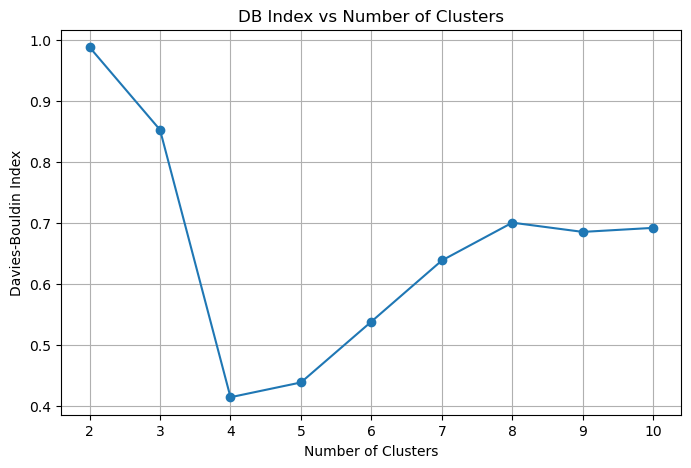

In [16]:
#  Visualizing Results
# Plotting DB Index vs Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid()
plt.show()


In [17]:
#importing more libraries for kmeans and DB score, Silhouette Score 
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [18]:
# Choosing again the range of clusters to evaluate
cluster_range = range(2, 11)
db_scores = []
silhouette_scores = []
kmeans_models = []


In [19]:
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    db_scores.append(davies_bouldin_score(features, labels))
    silhouette_scores.append(silhouette_score(features, labels))
    kmeans_models.append((kmeans, labels))

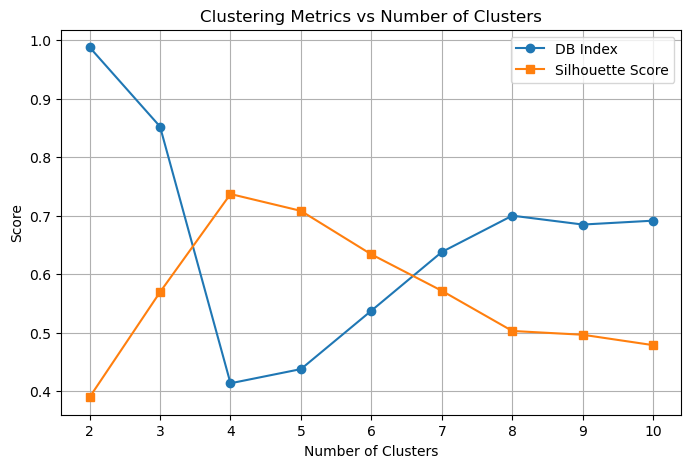

In [20]:
# Visualizing Results
# Plotting DB Index vs Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o', label='DB Index')
plt.plot(cluster_range, silhouette_scores, marker='s', label='Silhouette Score')
plt.title('Clustering Metrics vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [21]:
# Adding cluster labels to the dataset
data['Cluster'] = optimal_labels


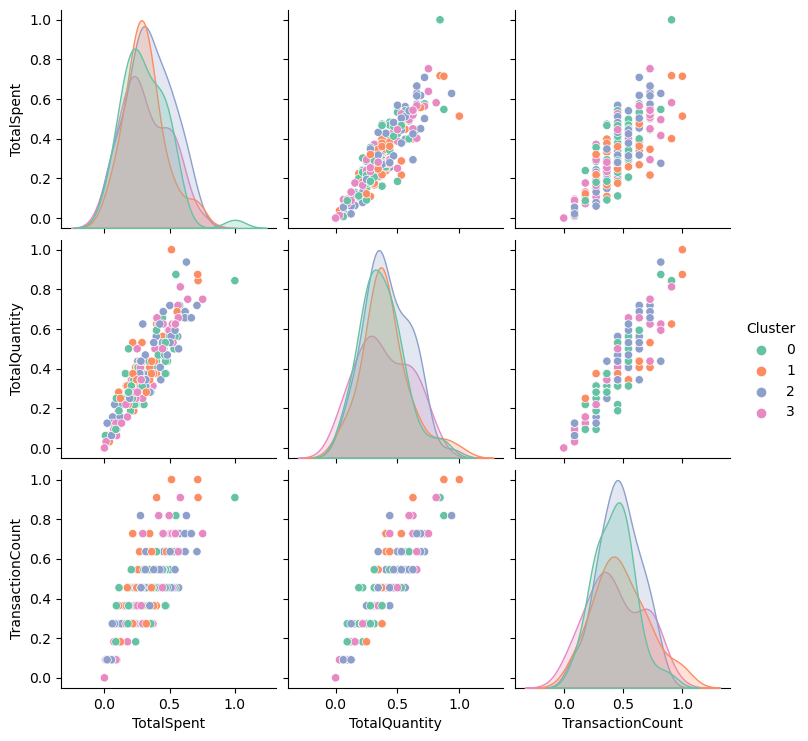

In [22]:
# Visualizing clusters using a pairplot (for numerical features)
sns.pairplot(data, hue='Cluster', vars=numerical_columns, palette='Set2')
plt.show()

In [23]:
from sklearn.decomposition import PCA

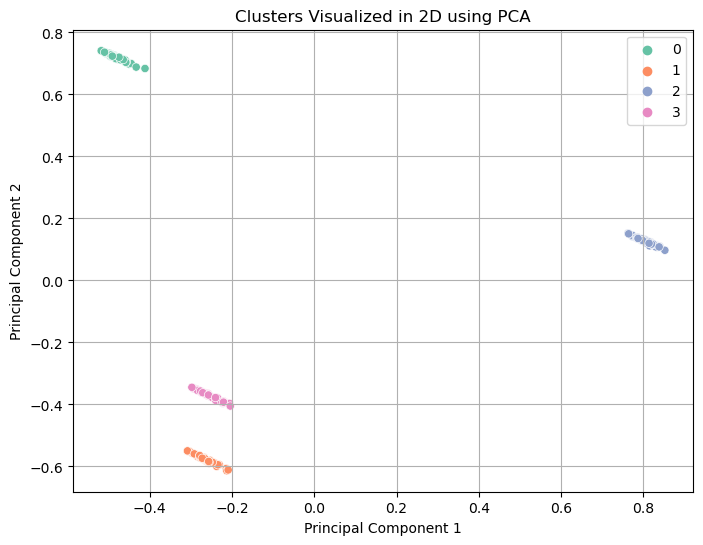

In [24]:
# PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=data['Cluster'], palette='Set2')
plt.title('Clusters Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [25]:
#  Report results
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(db_scores):.2f}")
print(f"Silhouette Score: {silhouette_scores[db_scores.index(min(db_scores))]:.2f}")


Optimal Number of Clusters: 4
Davies-Bouldin Index: 0.41
Silhouette Score: 0.74


In [26]:
# Saving the clustered data for further analysis
data.to_csv('CustomerSegmentation.csv', index=False)


In [27]:
print("Customer segmentation completed and results saved to CustomerSegmentation.csv!")


Customer segmentation completed and results saved to CustomerSegmentation.csv!


# A FEW MORE USEFUL CLUSTERING TECHNIQUES

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features)

# Evaluate clustering
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    silhouette_avg = silhouette_score(features, dbscan_labels)
    print(f"Silhouette Score for DBSCAN: {silhouette_avg:.2f}")
else:
    print("DBSCAN could not form distinct clusters.")

# Add cluster labels to the dataset
data['DBSCAN_Cluster'] = dbscan_labels


Silhouette Score for DBSCAN: 0.74


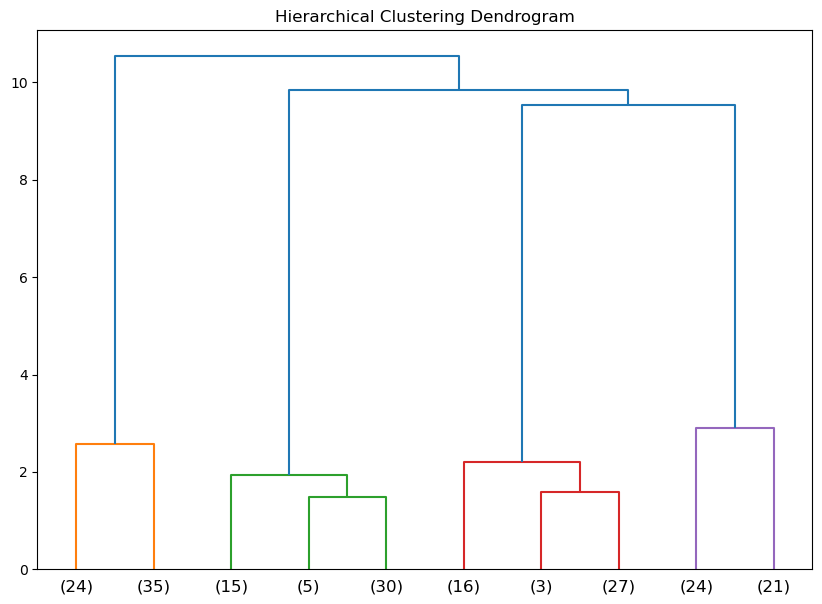

In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Perform hierarchical clustering
linkage_matrix = linkage(features, method='ward')
# Create dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Form clusters (set number of clusters)
hierarchical_labels = fcluster(linkage_matrix, t=4, criterion='maxclust')
data['Hierarchical_Cluster'] = hierarchical_labels


In [30]:
from sklearn.mixture import GaussianMixture

# Perform GMM clustering
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(features)

# Evaluate clustering
silhouette_avg = silhouette_score(features, gmm_labels)
print(f"Silhouette Score for GMM: {silhouette_avg:.2f}")

# Add cluster labels to the dataset
data['GMM_Cluster'] = gmm_labels


Silhouette Score for GMM: 0.74


In [31]:
from sklearn.cluster import Birch

# Perform Birch clustering
birch = Birch(n_clusters=4)
birch_labels = birch.fit_predict(features)

# Evaluate clustering
silhouette_avg = silhouette_score(features, birch_labels)
print(f"Silhouette Score for Birch: {silhouette_avg:.2f}")

# Add cluster labels to the dataset
data['Birch_Cluster'] = birch_labels


Silhouette Score for Birch: 0.74


In [32]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [33]:
import hdbscan

# Perform HDBSCAN clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
hdb_labels = hdb.fit_predict(features)

# Evaluate clustering
if len(set(hdb_labels)) > 1:  # Ensure at least 2 clusters
    silhouette_avg = silhouette_score(features, hdb_labels)
    print(f"Silhouette Score for HDBSCAN: {silhouette_avg:.2f}")
else:
    print("HDBSCAN could not form distinct clusters.")

# Add cluster labels to the dataset
data['HDBSCAN_Cluster'] = hdb_labels


Silhouette Score for HDBSCAN: 0.74


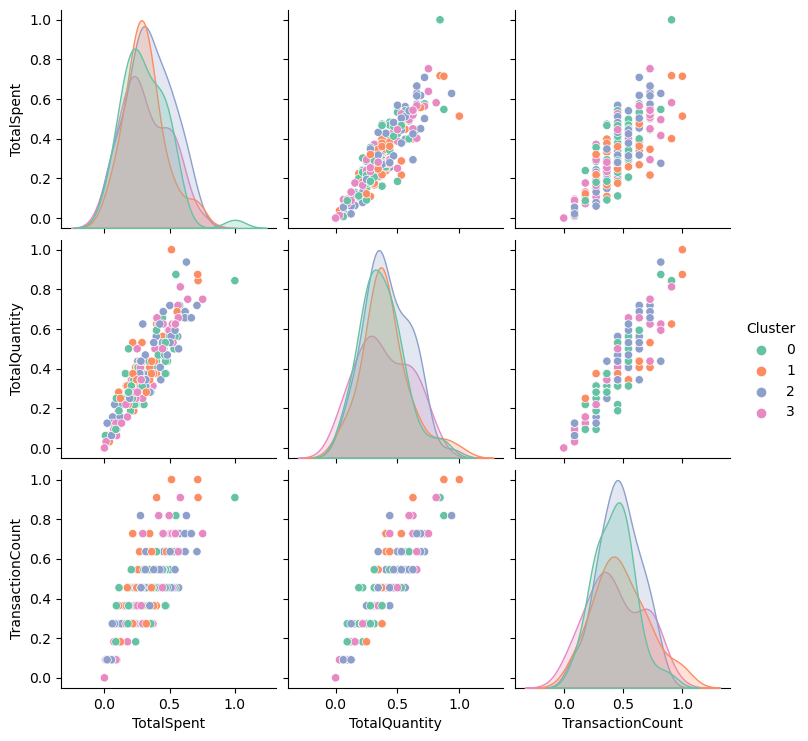

In [34]:
# Visualize clusters from one algorithm (e.g., K-Means)
sns.pairplot(data, hue='Cluster', vars=numerical_columns, palette='Set2')
plt.show()
